Importing Necessary Libraries

In [17]:
import numpy as np
import pandas as pd
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from scipy.spatial import distance

Reading data from path

In [12]:
train_data = pd.read_csv("C:/Users/Divine/Downloads/titanic/train.csv")
test_data = pd.read_csv("C:/Users/Divine/Downloads/titanic/test.csv")

Data Preprocessing

In [13]:
df = pd.concat([train_data,test_data], ignore_index = True, sort = False) 
#Like sibsp, this feature has number of parents ot children each passenger
#was travelling with. I made a new column named family by adding Parch and
# SibSp

df['Family'] = df.Parch + df.SibSp
#I concluded from here that more people survived who were travelling alone.
df['Alone'] = df.Family == 0

#There is also a possiblity that ticket price or fare was dependent on the
#survival chances, because the crew most probably gives more facility and
#priority to passengers who payed more
df['Fare_Category'] = pd.cut(df['Fare'], bins=[0,7.90,14.45,31.28,120],
                             labels=['Low','Mid',
                                     'High_Mid','High'])
#Imputation
#embarked column had only 2 missing values and since most people boarded from
#southhampton, I filled the missing values with southhampton
df.Embarked.fillna(df.Embarked.mode()[0], inplace = True)
#cabin
#As the column ‘Cabin’ had a lot of missing data. I decided to categorize all
#the missing data as a different class. I named it NA. I assigned all the
#missing values with this value.
df.Cabin = df.Cabin.fillna('NA')
#age
#age had also more missing values then I though of distributing people based
#on their salutations .
df['Salutation'] = df.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())
#grouped titles with Sex and Pclass
group = df.groupby(['Sex', 'Pclass'])
#I substituted median of the group in the missing rows
group.Age.apply(lambda x:x.fillna(x.median()))
df.Age.fillna(df.Age.median, inplace = True)
#encoding
#since Sex was assigned as male and female which is a string data, I
#converted them to numeric data .
from sklearn.preprocessing import LabelEncoder
df['Sex'] = LabelEncoder().fit_transform(df['Sex'])
#for other categorical data creating dummies
pd.get_dummies(df.Embarked, prefix='Emb', drop_first = True)
#Dropped the columns which I did not need for predictions and the columns
#I added by creating their dummies
df.drop(['Pclass', 'Fare','Cabin', 'Fare_Category','Name','Salutation', 'Ticket','Embarked', 'SibSp', 'Parch', 'Age'], axis=1, inplace=True)

Preparing Training and Testing Data

In [14]:
# Data to be predicted
X_to_be_predicted = df[df.Survived.isnull()]
X_to_be_predicted = X_to_be_predicted.drop(['Survived'], axis = 1)
# X_to_be_predicted[X_to_be_predicted.Age.isnull()]
# X_to_be_predicted.dropna(inplace = True) # 417 x 27
#Training data
train_data = df
train_data = train_data.dropna()
feature_train = train_data['Survived']
label_train  = train_data.drop(['Survived'], axis = 1)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(label_train, feature_train, test_size=0.2)

Building Naive Bayes Classifier from scratch

In [15]:
class NaiveBayes:
    def __init__(self):
        self.prior = {}
        self.conditional_probs = {}

    def fit(self, X_train, y_train):
        # Calculate class prior probabilities
        self.prior = dict(y_train.value_counts(normalize=True))

        # conditional probabilities for each feature
        for feature in X_train.columns:
            self.conditional_probs[feature] = {}
            unique_values = X_train[feature].unique()

            for value in unique_values:
                self.conditional_probs[feature][value] = {}

                for class_label in self.prior:
                    class_mask = (y_train == class_label)
                    count = X_train.loc[class_mask, feature].value_counts().get(value, 0)
                    total = class_mask.sum()
                    self.conditional_probs[feature][value][class_label] = (count + 1) / (total + len(unique_values))

    def predict(self, X_test):
        predictions = []

        for _, row in X_test.iterrows():
            posterior_probs = {}

            for class_label in self.prior:
                posterior_probs[class_label] = self.prior[class_label]

                for feature in X_test.columns:
                    feature_value = row[feature]
                    if feature_value not in self.conditional_probs[feature]:
                        posterior_probs[class_label] *= 1 / (X_test.shape[0] + 1)
                    else:
                        conditional_prob = self.conditional_probs[feature][feature_value][class_label]
                        posterior_probs[class_label] *= conditional_prob

            predicted_class = max(posterior_probs, key=posterior_probs.get)
            predictions.append(predicted_class)

        return predictions

Implementing Naive Bayes Classifier

In [16]:
naive_bayes = NaiveBayes()
naive_bayes.fit(x_train, y_train)
predictions = naive_bayes.predict(x_test)
print("Predictions:", predictions)
# After making predictions
correct_predictions = sum(predictions == y_test)
accuracy = correct_predictions / len(y_test)
print("Accuracy:", accuracy)

Predictions: [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]
Accuracy: 0.8212290502793296


Some Visualizations

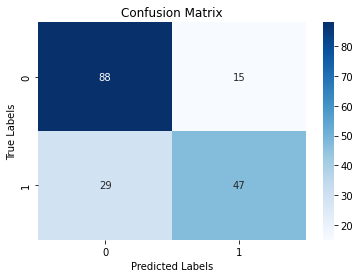

In [4]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


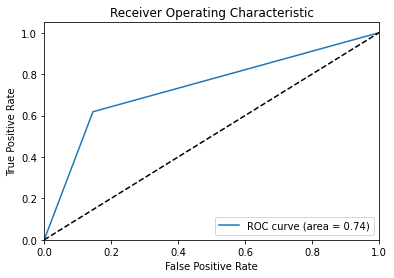

In [6]:
from sklearn.metrics import roc_curve, auc

# Calculate the false positive rate and true positive rate
fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Building KNN classifier from scratch

In [18]:
class KNNClassifier:
    def __init__(self, k):
        self.k = k

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        predictions = []

        for _, row in X_test.iterrows():
            distances = []

            for _, train_row in self.X_train.iterrows():
                dist = distance.euclidean(row.values, train_row.values)
                distances.append(dist)

            nearest_indices = np.argsort(distances)[:self.k]
            nearest_labels = self.y_train.iloc[nearest_indices]
            predicted_class = nearest_labels.mode()[0]
            predictions.append(predicted_class)

        return predictions


In [20]:
# Initialize and train the KNN classifier
knn_classifier = KNNClassifier(k=3)
knn_classifier.fit(x_train, y_train)

# Make predictions on the test dataset
predictions = knn_classifier.predict(x_test)

# Print the predictions
print("Predictions:", predictions)
correct_predictions = sum(predictions == y_test)
accuracy = correct_predictions / len(y_test)
print("Accuracy:", accuracy)

Predictions: [0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0]
Accuracy: 0.5363128491620112


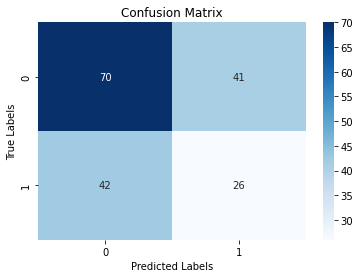

In [21]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

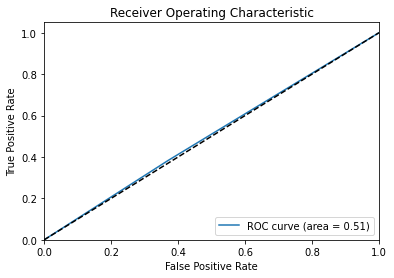

In [22]:
from sklearn.metrics import roc_curve, auc

# Calculate the false positive rate and true positive rate
fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()